In [30]:
import numpy as np
import matplotlib.pyplot as plt


In [36]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 10
        self.width =  10
        self.grid = np.zeros(( self.height, self.width)) - 1
        self.walls = []
        # Set random start location for the agent
        self.current_location = (0, 0)

        # Set locations for the gold
        self.gold_location = (9,4)
        self.terminal_states = [ self.gold_location]
        self.walls = [                     (0,3), (0,4), (0,5),
                             (1,1),        (1,3),                      (1,7),
                             (2,1), (2,2), (2,3),        (2,5), (2,6), (2,7), (2,8), 
                             (3,1),                      (3,5),
                             (4,1),        (4,3), (4,4), (4,5),        (4,7), (4,8), 
                             (5,1),        (5,3),                             (5,8),
                             (6,1), (6,2), (6,3),        (6,5), (6,6), (6,7), (6,8),
                             (7,1),                      (7,5),               (7,8),
                             (8,1),        (8,3), (8,4), (8,5),        (8,7), (8,8),    
                                           (9,3)
                      ]

        # Set grid rewards for special cells
        self.grid[ self.gold_location[0], self.gold_location[1]] = 99

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0 or (self.current_location[0] - 1, self.current_location[1]) in self.walls:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1 or (self.current_location[0] + 1, self.current_location[1]) in self.walls:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0 or (self.current_location[0], self.current_location[1] - 1) in self.walls:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1 or (self.current_location[0], self.current_location[1] + 1) in self.walls:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [32]:
class QLearningAgent():
    def __init__(self, actions, learning_rate, discount_factor, exploration_prob):
        self.height = 10
        self.width =  10
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.Q_table = np.zeros((self.height, self.width, len(self.actions)))
    
    def choose_action(self, current_state):
        if np.random.rand() < self.exploration_prob:
            action = self.actions[np.random.randint(0, len(self.actions))]
        else:
            action = self.actions[np.argmax(self.Q_table[current_state])]
        return action
    
    def add_reward(self, current_state, action, reward, next_state):
        action_ = self.actions.index(action)
        self.Q_table[current_state][action_] += self.learning_rate * \
            (reward + self.discount_factor *
            np.max(self.Q_table[next_state]) - self.Q_table[current_state][action_])
        
    def print_Q_table(self):
        for row in self.Q_table:
            # Print UP and DOWN actions on one row
            for cell in row:
                for i, q_value in enumerate(cell):
                    if i < 2:
                        print("{:6.2f}".format(q_value), end=" ")  # Adjusted width to 6
                print("|", end=" ")
            print()
            
            # Print LEFT and RIGHT actions on another row
            for cell in row:
                for i, q_value in enumerate(cell):
                    if i >= 2:
                        print("{:6.2f}".format(q_value), end=" ")  # Adjusted width to 6
                print("|", end=" ")
            print()
            print("-" * 2 * (len(row) * 8 - 1))  # Separator line


In [33]:
def play(environment, agent, trials=500, max_steps_per_episode=1000):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for _ in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_location = environment.current_location
            action = agent.choose_action(old_location)
            reward = environment.make_step(action)
            agent.add_reward(old_location, action, reward, environment.current_location) 
            
            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

 -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 |   0.00   0.00 |   0.00   0.00 |   0.00   0.00 |  -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 | 
 -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 |   0.00   0.00 |   0.00   0.00 |   0.00   0.00 |  -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 |  -1.00  -1.00 | 
--------------------------------------------------------------------------------------------------------------------------------------------------------------
 -1.00  -1.00 |   0.00   0.00 |  -1.00  -1.00 |   0.00   0.00 |  -0.99  -0.99 |  -1.00  -0.99 |  -1.00  -0.99 |   0.00   0.00 |  -1.00  -1.00 |  -1.00  -1.00 | 
 -1.00  -1.00 |   0.00   0.00 |  -1.00  -1.00 |   0.00   0.00 |  -1.00  -0.99 |  -0.99  -0.99 |  -0.99  -0.99 |   0.00   0.00 |  -1.00  -1.00 |  -1.00  -1.00 | 
--------------------------------------------------------------------------------------------------------------------------------------------------------------
 -1.00  -1.00 |   0.00   0.00 |   0.00

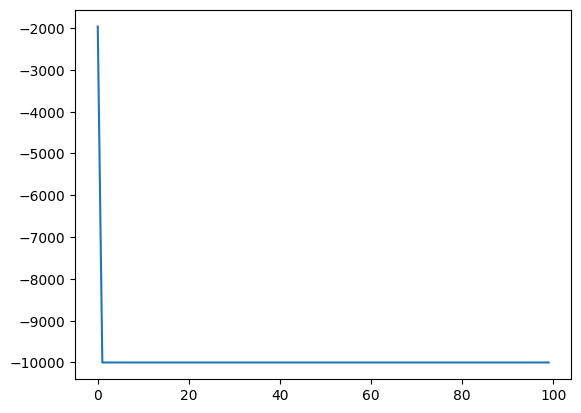

In [46]:
# Initialize environment and agent
environment = GridWorld()
random_agent = QLearningAgent(environment.get_available_actions(), learning_rate = 0.7, discount_factor = 0, exploration_prob = 0.2)

reward_per_episode = play(environment, random_agent, trials=100, max_steps_per_episode=10000)

random_agent.print_Q_table()

# Simple learning curve
plt.plot(reward_per_episode)

print("Final:", reward_per_episode[-1])
print("Best:", max(reward_per_episode))